In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-10-30 23:35:44.628962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# Define the folder where images are stored
script_dir = os.getcwd()
folder_path = os.path.join(f'{script_dir}/','Training/notumor')

# List to store image data for exploration
image_data = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Supported image formats
        # Open image using Pillow
        image_path = os.path.join(folder_path, filename)
        img = Image.open(image_path)
        
        # Append image data to the list
        image_data.append({
            'filename': filename,
            'size': img.size,  # (width, height)
            'mode': img.mode,  # Image mode like "RGB", "L", etc.
            'format': img.format  # Image format like "JPEG", "PNG", etc.
        })
        
        # Display the image using matplotlib
        #plt.imshow(np.array(img))  # Convert image to numpy array for displaying
        #plt.title(f'Image: {filename}')
        #plt.axis('off')  # Hide axes
        #plt.show()

# Display some basic information about the images
for data in image_data:
    print(f"Filename: {data['filename']}, Size: {data['size']}, Mode: {data['mode']}, Format: {data['format']}")


Filename: Tr-no_0798.jpg, Size: (206, 244), Mode: RGB, Format: JPEG
Filename: Tr-no_1486.jpg, Size: (227, 222), Mode: RGB, Format: JPEG
Filename: Tr-no_0940.jpg, Size: (208, 248), Mode: RGB, Format: JPEG
Filename: Tr-no_1492.jpg, Size: (339, 340), Mode: RGB, Format: JPEG
Filename: Tr-no_0954.jpg, Size: (225, 225), Mode: RGB, Format: JPEG
Filename: Tr-no_0968.jpg, Size: (236, 236), Mode: RGB, Format: JPEG
Filename: Tr-no_1323.jpg, Size: (206, 244), Mode: RGB, Format: JPEG
Filename: Tr-no_1445.jpg, Size: (225, 225), Mode: RGB, Format: JPEG
Filename: Tr-no_0983.jpg, Size: (201, 250), Mode: RGB, Format: JPEG
Filename: Tr-no_1451.jpg, Size: (400, 442), Mode: RGB, Format: JPEG
Filename: Tr-no_0997.jpg, Size: (196, 257), Mode: RGB, Format: JPEG
Filename: Tr-no_0029.jpg, Size: (630, 630), Mode: RGB, Format: JPEG
Filename: Tr-no_1337.jpg, Size: (225, 225), Mode: RGB, Format: JPEG
Filename: Tr-no_1479.jpg, Size: (300, 168), Mode: RGB, Format: JPEG
Filename: Tr-no_0767.jpg, Size: (201, 250), Mode

In [3]:
#
# Unzip the data file and place the "Training" folder same level as this script
# Ref: #https://www.kaggle.com/code/ahmedhassansaqr/brain-tumor-detection-using-cnn/notebook
#

script_dir = os.getcwd()
no_tumor_dir = os.path.join(f'{script_dir}/','Training/notumor')
yes_tumor_gli_dir = os.path.join(f'{script_dir}/','Training/glioma')
yes_tumor_men_dir = os.path.join(f'{script_dir}/','Training/meningioma')
yes_tumor_pit_dir = os.path.join(f'{script_dir}/','Training/pituitary')

#no_tumor_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no'
#yes_tumor_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes'

In [4]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
    return images

def load_random_images_from_folder(folder, num_images=10):
    images = []

    image_filenames = [f for f in os.listdir(folder) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

    selected_filenames = random.sample(image_filenames, min(len(image_filenames), num_images))
    
    for filename in selected_filenames:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resize image to 128x128
            images.append(img)
    
    return images

no_tumor_images = load_random_images_from_folder(no_tumor_dir, 10)
yes_tumor_gli_images = load_random_images_from_folder(yes_tumor_gli_dir,10)
yes_tumor_men_images = load_random_images_from_folder(yes_tumor_men_dir, 10)
yes_tumor_pit_images = load_random_images_from_folder(yes_tumor_pit_dir, 10)

no_tumor_labels = [0] * len(no_tumor_images)
yes_tumor_gli_labels = [1] * (len(yes_tumor_gli_images))
yes_tumor_men_labels = [2] * (len(yes_tumor_men_images))
yes_tumor_pit_labels = [3] * (len(yes_tumor_pit_images))

Initial shape or dimensions of X (40, 128, 128, 3)
Number of samples in our data: 40
Number of labels in our data: 40
Dimensions of images:(128, 128, 3)


<Figure size 640x480 with 0 Axes>

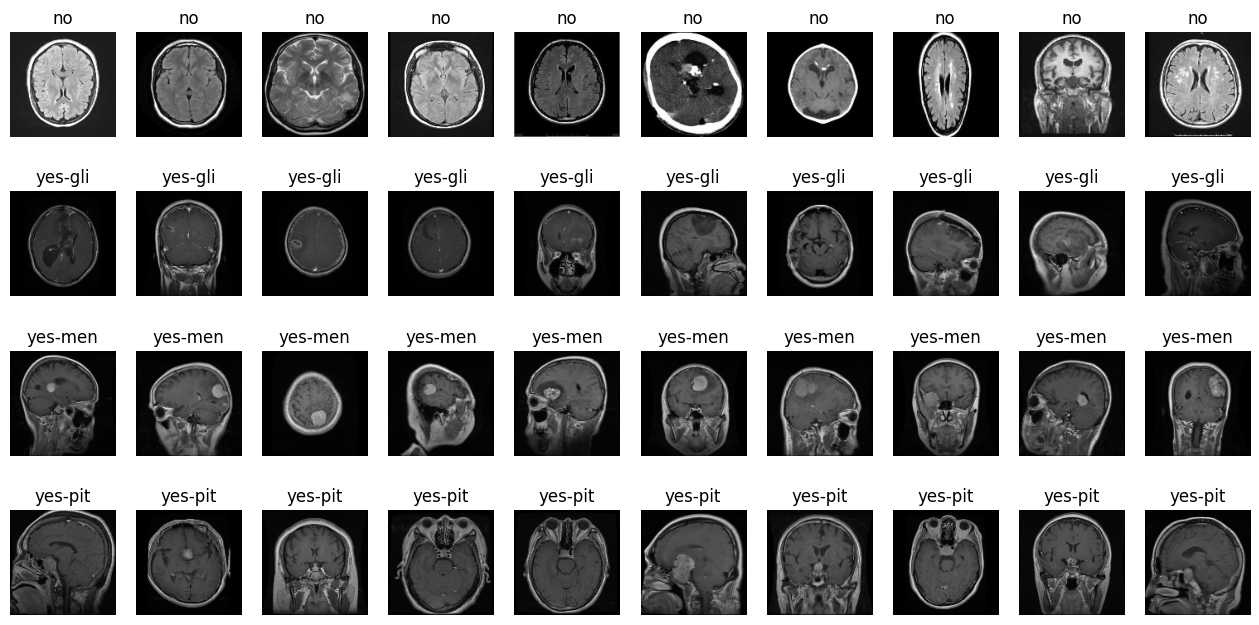

In [5]:
X = np.array(no_tumor_images + yes_tumor_gli_images + yes_tumor_men_images + yes_tumor_pit_images)
y = np.array(no_tumor_labels + yes_tumor_gli_labels + yes_tumor_men_labels + yes_tumor_pit_labels)

print("Initial shape or dimensions of X", str(X.shape))
print ("Number of samples in our data: " + str(len(X)))
print ("Number of labels in our data: " + str(len(y)))
print ("Dimensions of images:" + str(X[0].shape))

figure = plt.figure()
plt.figure(figsize=(16,10))

num_of_images = 40 
classes = ["no", "yes-gli","yes-men","yes-pit"]
for index in range(1, num_of_images + 1):
    class_names = classes[y[index-1]]
    plt.subplot(5, 10, index).set_title(f'{class_names}')
    plt.axis('off')
    plt.imshow(X[index-1], cmap='gray_r')

In [6]:
X = X.astype('float32')
img_rows = X[0].shape[0]
img_cols = X[0].shape[1]
input_shape = (img_rows, img_cols, 3)

X /= 255.0
y = to_categorical(y, num_classes=4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [15]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [16]:
L2 = 0.001

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss = 'categorical_crossentropy',
              optimizer = SGD(0.01),
              metrics = ['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 57600)             0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [17]:
history = model.fit(X_train, y_train, batch_size = 8,
                              epochs = 50,
                              validation_data = (X_test, y_test),
                              verbose = 1,)

Epoch 1/50
4/4 [==============================] - 0s 80ms/step - loss: 1.3688 - accuracy: 0.2188 - val_loss: 1.4038 - val_accuracy: 0.1250
Epoch 2/50
4/4 [==============================] - 0s 55ms/step - loss: 1.2730 - accuracy: 0.3438 - val_loss: 1.4485 - val_accuracy: 0.1250
Epoch 3/50
4/4 [==============================] - 0s 56ms/step - loss: 1.1737 - accuracy: 0.2812 - val_loss: 1.4289 - val_accuracy: 0.1250
Epoch 4/50
4/4 [==============================] - 0s 55ms/step - loss: 1.1084 - accuracy: 0.4375 - val_loss: 1.4180 - val_accuracy: 0.1250
Epoch 5/50
4/4 [==============================] - 0s 55ms/step - loss: 1.1153 - accuracy: 0.3438 - val_loss: 1.5150 - val_accuracy: 0.1250
Epoch 6/50
4/4 [==============================] - 0s 59ms/step - loss: 0.9828 - accuracy: 0.4688 - val_loss: 1.3859 - val_accuracy: 0.1250
Epoch 7/50
4/4 [==============================] - 0s 57ms/step - loss: 0.9367 - accuracy: 0.5938 - val_loss: 1.4711 - val_accuracy: 0.2500
Epoch 8/50
4/4 [===========

In [18]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

1/1 [==============================] - 0s 82ms/step


In [19]:
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.75      0.75      0.75         4
           2       1.00      0.50      0.67         2
           3       0.00      0.00      0.00         1

    accuracy                           0.62         8
   macro avg       0.56      0.56      0.52         8
weighted avg       0.69      0.62      0.62         8



<Axes: >

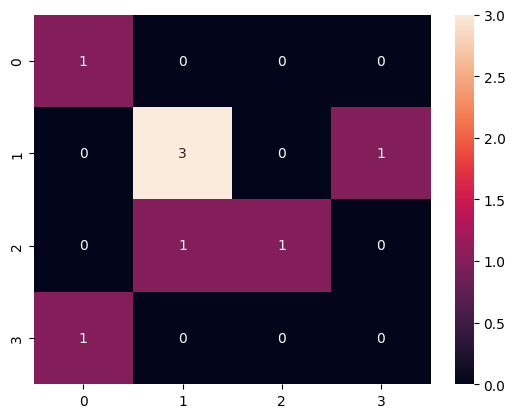

In [20]:
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True)